# komet : Kronecker Optimized METhod for DTI prediction

1. Downloading the dataset (train/val/test) from Github 
2. Choosing parameters of approximation (Nystrom and features dimension)
3. Calculating of molecule features using a subsample of train molecules (MorganFP kernel approximated via Nystrom approximation)
4. Calculating of protein features (SVD on LAkernel)
5. Train/Testing with a chosen lambda

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import pickle

import time 

from sklearn.metrics import  average_precision_score,  roc_curve, confusion_matrix, precision_score, recall_score, auc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32

cpu


In [ ]:
!pip install rdkit

### 1. Download the data from a GitHub repo.

#### Download train/val/test

In [ ]:
!mkdir data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/LCIdb/Orphan/test.csv
!mv test.csv data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/LCIdb/Orphan/train.csv.zip
!mv train.csv.zip data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/LCIdb/Orphan/val.csv
!mv val.csv data/

#### Download utils

In [ ]:
!mkdir data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/dict_ind2fasta_all.data
!mv dict_ind2fasta_all.data data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/data/dict_ind2fasta_LCIdb_K_prot.data
!mv dict_ind2fasta_LCIdb_K_prot.data data/
!wget -q https://github.com/Guichaoua/chemogenomic/raw/main/komet/komet.py

In [2]:
import sys
sys.path.append('../komet')  # Ajoute le répertoire parent au chemin de recherche des modules
import komet 

cpu


In [15]:
dataset_dir = "data/"

# load data
train = komet.load_df("train.csv.zip",dataset_dir)
val = komet.load_df("val.csv",dataset_dir)
test = komet.load_df("test.csv",dataset_dir)

# dataframe full has all smiles and fasta sequences
full = pd.concat([train, val, test])
print("full shape",full.shape)

number of smiles to clean: 0
train.csv shape (236530, 3)
number of smiles to clean: 0
val.csv shape (21844, 3)
number of smiles to clean: 0
test.csv shape (45005, 3)
full shape (303379, 3)


### 3. Calculation of molecule features using a subsample of train molecules (molecule kernel approximated via Nystrom approximation)


In [19]:
#### MOLECULE####
# Index of the smiles in the dataset
list_smiles = full[['SMILES']].drop_duplicates().values.flatten()
nM = len(list_smiles)
print("number of different smiles (mol):",nM)
dict_smiles2ind = {list_smiles[i]:i for i in range(nM)}

# add indsmiles in train, val, test
train['indsmiles'] = train['SMILES'].apply(lambda x:dict_smiles2ind[x] )
val['indsmiles'] = val['SMILES'].apply(lambda x: dict_smiles2ind[x])
test['indsmiles'] = test['SMILES'].apply(lambda x: dict_smiles2ind[x])

number of different smiles (mol): 143255


In [20]:
# molecule kernel_first step : compute Morgan FP for each smiles of all the dataset
MorganFP = komet.Morgan_FP(list_smiles)

In [22]:
# compute the Nystrom approximation of the mol kernel 
mM = 3000 #all mol to compute the mol kernel for medium-scale database
rM = 1000 #all dim for the mol features for medium-scale database

# In case there are less molecules than the number of molecules to compute the Nystrom approximation
mM = min(mM,nM) # number of molecule to compute nystrom
rM = min(rM,nM) # final dimension of features for molecules
print("mM",mM,"rM",rM)

# compute the Nystrom approximation of the mol kernel and the features of the Kronecker kernel (features normalized and calculated on all mol contained in the dataset (train/val/test))
X_cn = komet.Nystrom_X_cn(mM,rM,nM,MorganFP)
print("mol features shape",X_cn.shape)

mM 3000 rM 1000
mol kernel shape torch.Size([3000, 143255])
mol features shape torch.Size([143255, 1000])


### 4. Loading protein features 

In [23]:
# Index of the protein in the dataset
fasta = full[['Target Sequence']].drop_duplicates().values.flatten() # fasta sequence on the dataset, in the same order as the dataset
print("number of different Fasta (protein):",len(fasta))
# add ind_fasta dans train, val et test
train['indfasta'] = train['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
val['indfasta'] = val['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
test['indfasta'] = test['Target Sequence'].apply(lambda x:  np.where(fasta==x)[0][0])

number of different Fasta (protein): 2069


In [27]:
# Load Protein kernel and dictionary of index
dict_ind2fasta_LCIdb = pickle.load(open(dataset_dir + "dict_ind2fasta_LCIdb.data", 'rb'))
dict_fasta2ind_LCIdb = {fasta:ind for ind,fasta in dict_ind2fasta_LCIdb.items()}
with open(dataset_dir + "dict_ind2fasta_LCIdb_K_prot.data", 'rb') as f:
    KP_LCIdb = pickle.load(f)
KP_LCIdb.shape, type(KP_LCIdb)

((2069, 2069), numpy.ndarray)

In [30]:
# Protein kernel for the dataset
I_fasta = [int(dict_fasta2ind_LCIdb[fasta[i]]) for i in range(len(fasta))] # index of fasta in the precomputed dict and protein kernel, in the same order as the dataset
KP = KP_LCIdb[I_fasta,:][:,I_fasta]
KP = torch.tensor(KP, dtype=mytype).to(device)
print("kernel prot shape",KP.shape)

kernel prot shape torch.Size([2069, 2069])


In [32]:
# computation of feature for protein (no nystrom, just SVD)
rP = KP.shape[0]#min(KP.shape[0],500)
U, Lambda, VT = torch.svd(KP)
Y = U[:,:rP] @ torch.diag(torch.sqrt(Lambda[:rP]))

# nomramlisation of the features
Y_c = Y - Y.mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]
print("protein features shape",Y.shape)

protein features shape torch.Size([2069, 2069])


### Load interactions index for train and test 

In [33]:
# Train
I, J, y = komet.load_datas(train)
n = len(I)
print("len(train)",n)

len(train) 236530


In [35]:
# Test
I_test, J_test, y_test = komet.load_datas(test)
n_test = len(I_test)
print("len(test)",n_test)

len(test) 45005


### Training/Testing with a choosen lambda

In [47]:
#### TRAINING ####
lamb = 1e-6
# train the model
w_bfgs,b_bfgs,history_lbfgs_SVM = komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb,niter=50)
# compute a probability using weights (Platt scaling)
s,t,history_lbfgs_Platt = komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y,I,J,niter=20)

cpu
L-BFGS time: 183.8898 seconds


In [48]:
#### TRAIN ####
# we compute a probability using weights (Platt scaling)
m_train,y_pred_train, proba_pred_train = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I,J)
# we compute the results
acc1_train,au_Roc_train,au_PR_train,thred_optim_train,acc_best_train,cm_train,FP_train = komet.results(y.cpu(),y_pred_train.cpu(),proba_pred_train.cpu())
print(f"roc AUC = {au_Roc_train:.4f}")
print(f"AUPR = {au_PR_train:.4f}")
print(f"accuracy (threshold 0.5)= {acc1_train:.4f}")
print(f"best threshold = {thred_optim_train:.4f}")
print(f"accuracy (best threshold)= {acc_best_train:.4f}")
print(f"false positive (best threshold)= {FP_train:.4f}")

roc AUC = 0.9994
AUPR = 0.9990
accuracy (threshold 0.5)= 0.9976
best threshold = 0.5421
accuracy (best threshold)= 0.9976
false positive (best threshold)= 0.0030


In [49]:
#### TEST ####
# we compute a probability using weights (Platt scaling)
m,y_pred, proba_pred = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_test,J_test)
# we compute the results
acc1,au_Roc,au_PR,thred_optim,acc_best,cm,FP = komet.results(y_test.cpu(),y_pred.cpu(),proba_pred.cpu())
print(f"roc AUC = {au_Roc:.4f}")
print(f"AUPR = {au_PR:.4f}")
print(f"accuracy (threshold 0.5)= {acc1:.4f}")
print(f"best threshold = {thred_optim:.4f}")
print(f"accuracy (best threshold)= {acc_best:.4f}")
print(f"false positive (best threshold)= {FP:.4f}")

roc AUC = 0.8797
AUPR = 0.8965
accuracy (threshold 0.5)= 0.6765
best threshold = 0.0008
accuracy (best threshold)= 0.8092
false positive (best threshold)= 0.1799


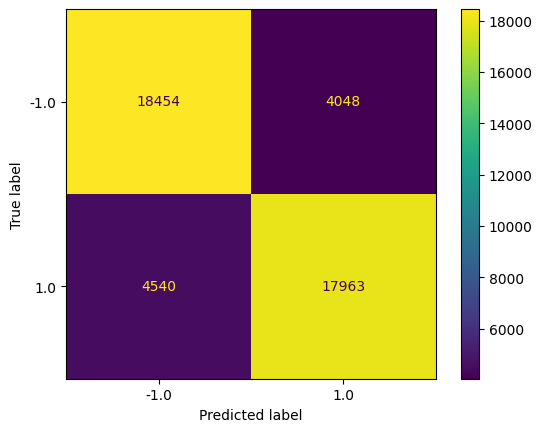

In [50]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = [-1., 1.]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

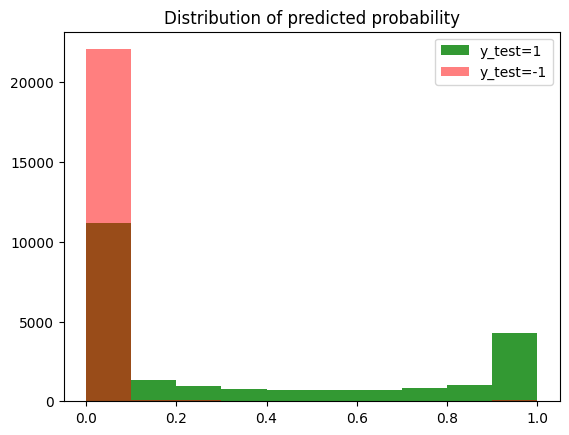

In [51]:
# plot distribution (density) of p when y_test=1
plt.hist(proba_pred.cpu().numpy()[y_test.cpu().numpy()==1],bins=10,alpha=0.8,color='green',label='y_test=1');
plt.hist(proba_pred.cpu().numpy()[y_test.cpu()==-1],bins=10,alpha=0.5,color='red',label='y_test=-1');
plt.legend()
plt.title('Distribution of predicted probability')
plt.show()